# 3. CKY parsing

## Preparation

In [1]:
import matplotlib.pyplot as plt
import nltk

import time
from collections import defaultdict

from dataset import load_sentences, load_grammar
from parser import CkyParser
from measure import tree_f1_score


OUTPUT_PARSING_RESULTS_PATH = "./parsing_results.txt"

if False:  # Set this as True if it is your first time use NLTK grammer
    nltk.download("large_grammars")

In [2]:
# Grammar and corpus loading
# Extra points inside: I implemented my own conversion function
grammar = load_grammar()
sentences, gt_counts = load_sentences()
assert len(sentences) == len(gt_counts)
parser = CkyParser(grammar)
print("Number of sentences:", len(sentences))
print(grammar)

Number of sentences: 98
Grammar with 16310 productions (start state = SIGMA)
    AJP_JJ -> ADJ_JJ PP_NP
    AVPNP_NNS -> 'mornings'
    PREP_IN -> 'by'
    NP_NN -> __NP_NN__ADJ_DT__NOUN_NN__ AJP_JJ
    NOUN_NPS -> 'missouri'
    orient -> 'orient'
    SIGMA -> c p
    DECL_VBZ -> __DECL_VBZ__NP_NNS__VERB_VBZ__PP_NP__PP_NP__PP_NN__ pt_char_per
    SIGMA -> __NP_NN__ADJ_AT__NP_NN__NOUN_NN__ PP_NNS
    NP_NN -> 'arrival'
    __DECL_HV__NP_NNS__VERB_DOZ__NP_NP__VERB_HV__PRPRTCL_VBG__ -> __DECL_HV__NP_NNS__VERB_DOZ__NP_NP__VERB_HV__ PRPRTCL_VBG
    __PP_NN__PREP_IN__NP_NP__NP_NNS__NOUN_NN__PP_NP__ -> __PP_NN__PREP_IN__NP_NP__NP_NNS__NOUN_NN__ PP_NP
    SIGMA -> __NP_NNS__AVP_RB__NOUN_NNS__PP_NNS__ pt_char_per
    SIGMA -> __NREL_BER__NP_DT__pt_verb_ber__ NP_NN
    SIGMA -> __NOUN_CD__seven__a_m___to__ten__ p_m
    __DECL_VB__NP_WPS__AVP_RB__VERB_VB__PP_NPS__ -> __DECL_VB__NP_WPS__AVP_RB__VERB_VB__ PP_NPS
    pt_adj_jjt -> 'longest'
    AVPNP_CD -> seven hundred
    INFCL_VB -> __INFCL_VB__

In [3]:
# Compare with NLTK parser to see if I loaded the grammar correctly
if True:    # It will take ~1min
    nltk_parser = nltk.parse.BottomUpChartParser(grammar)
    for senten, gt_cnt in zip(sentences, gt_counts):
        try:
            chart = nltk_parser.chart_parse(senten)
        except ValueError:  # The parser will raise an ValueError with unknown words.
            assert gt_cnt == 0
            continue
        # Utilize generator to avoid creating the full list, which wastes time and space.
        cnt = sum(1 for _ in chart.parses(grammar.start()))
        assert gt_cnt == cnt
    print("Grammar is loaded correctly.")

Grammar is loaded correctly.


## Recognizer

In [4]:
# Test the recognizer on the ATIS test sentences
for senten, gt_cnt in zip(sentences, gt_counts):
    accepted = parser.recognize(senten)
    accepted_gt = gt_cnt > 0
    assert accepted == accepted_gt
print("My recognizer pass test on all sentences.")

My recognizer pass test on all sentences.


In [5]:
# Feeding it other sentences to see whether it properly rejects ungrammatical sentences as well.
grammatical_sentences = [
    "Hello .",
    "I am a flight .",
    "I am not a city .",
]
ungrammatical_sentences = [
    "I am ChatGPT .",
    "flight am a I .",
    "42 .",
    "Tatakai .",
    "Viva la Vida .",
]
# Should use .lower().split() before fedding into parser, because the grammar only accepts lowercase words.

# Test grammatical sentences
for senten in grammatical_sentences:
    assert parser.recognize(senten.lower().split())
    print(f"{senten:24} is grammatical")

print("-"*41)

# Test ungrammatical sentences. It's notable that number and some words are unable to be recognized.
for senten in ungrammatical_sentences:
    assert not parser.recognize(senten.lower().split())
    print(f"{senten:24} is ungrammatical")

Hello .                  is grammatical
I am a flight .          is grammatical
I am not a city .        is grammatical
-----------------------------------------
I am ChatGPT .           is ungrammatical
flight am a I .          is ungrammatical
42 .                     is ungrammatical
Tatakai .                is ungrammatical
Viva la Vida .           is ungrammatical


**Discussion**

- Strange sentences that don't make sense can be grammatical. For example, nobody will say `i am a flight .`.
- What is judged as ungrammatical may not actually be grammatical. For example, `I am ChatGPT .` is grammatical (and also make sense). But it was refused by the parser because `ChatGPT` is a word that never occur in the grammar used by the parser.
- Sentences in other languages, e.g. `Tatakai .`, `Viva la Vida`​, ​are highly likely to be rejected for the same reason that their words not occur in the grammar.
- There should be only a few numbers, or even none, that can be identified. We might need a universal replacement word to preprocess all numbers.

## Counter (Extra point)

In [6]:
# Submit my parsing results (number of parses per sentence),
# as a text file with one line of the form sentence\t#parses
# for each test sentence, where \t is a tab character

result_lines = list()
for senten, gt_cnt in zip(sentences, gt_counts):
    # check my parse tree counts against the counts in NLTK
    assert parser.count(senten) == gt_cnt
    result_lines.append(f"{' '.join(senten)}\t#{gt_cnt}")
    print(result_lines[-1])  # print my parsing results
if True:  # save into file
    with open(OUTPUT_PARSING_RESULTS_PATH, "w", encoding="utf-8") as file:
        file.write("\n".join(result_lines))

i need a flight from charlotte to las vegas that makes a stop in saint louis .	#2085
what is the cheapest one way flight from phoenix to san diego that arrives in the morning on thursday june second .	#1380
what is the cheapest one way flight from columbus to indianapolis .	#50
is there a flight from memphis to los angeles .	#18
what aircraft is this .	#0
please show me the flights from chicago to detroit that arrive at six p.m. next tuesday .	#20
what flights are available between chicago and indianapolis next wednesday between eleven a.m. and one p.m .	#0
please book a one way coach fare from chicago to indianapolis on united flight two ninety two next wednesday .	#0
show me flights from chicago to kansas city leaving around seven p.m. thursday .	#1059
show american flights after twelve p.m. from miami to chicago .	#0
does united flight four seven four slash fourteen eighty four serve dinner .	#0
what kind of aircraft is american 's flight fifteen oh one that departs at six fifty nin

## Parser

In [7]:
# Test the correctness
for senten, gt_cnt in zip(sentences, gt_counts):
    assert len(parser.parse(senten)) == gt_cnt
print("My parser pass test on all sentences.")

My parser pass test on all sentences.


In [8]:
# Draw all the trees of a sentence with 4 parses
senten = sentences[-9]
trees = parser.parse(senten)
print(f"{' '.join(senten)}\t#{len(trees)}")

what are the costs .	#4


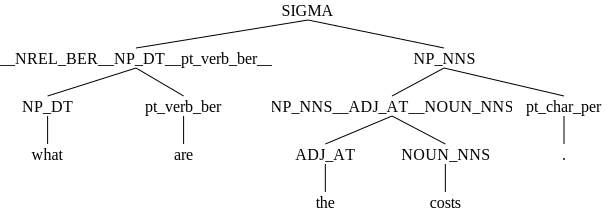

In [9]:
trees[0]

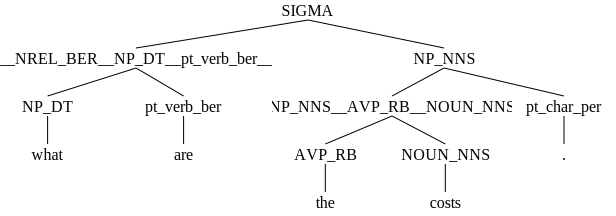

In [10]:
trees[1]

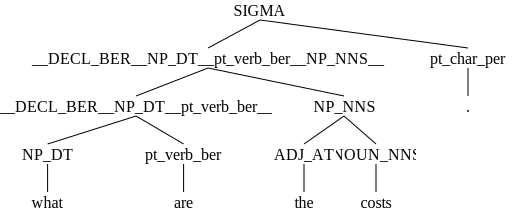

In [11]:
trees[2]

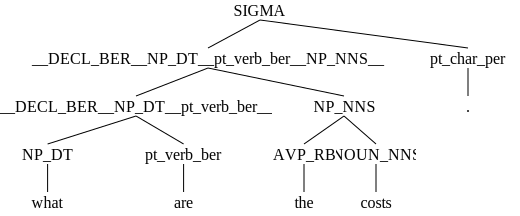

In [12]:
trees[3]

**Discussion**

The results could be grouped as two pairs. `trees[0]` and `trees[1]` are same in the structurs, `trees[2]` and `trees[3]` are also. Comparing inside the groups, we could found that the difference attributable to the `nonterminal` of word `the` for both the two groups.

I found the production rules below in `atis.cfg`:
```
ADJ_AT -> the
ADJ_AT -> a
ADJ_AT -> no
ADJ_AT -> pt_adj_at
```
and 
```
AVP_RB -> ADV_RB
ADV_RB -> the
the -> "the"
```

Because the normalized CFG should reduce rules like `A -> B -> C -> T` into `A -> T`, the last three rules above should be reduced as `AVP_RB -> "the"`

By asking Gemini, I got:

> Q: what do non-terminal `NP_NNS`, `ADV_RB`, `AVP_RB`, and `ADJ_AT` mean in parsing task in NLP?
>
> `NP_NNS` (Noun Phrase rooted in a Plural Noun): A Noun Phrase where the head word is a plural noun.
>
> `ADJ_AT` (Article acting as an Adjective): An article (determiner) that is functionally categorized as a type of adjective in this specific grammar.
> 
> `AVP_RB` (Adverb Phrase): An Adverb Phrase headed by an adverb.
> 
> `ADV_RB` (Adverb Word): A specific Adverb word.

Based on the definitions given my Gemini, the conclusion is: Because the CFG do not care about the POS, `the` will be parsed as a component of `ADV` once, and then as a component of `ADJ` again. This resulted in two trees in each group.

# Extra Points

## Sentence Length vs. Time

In [13]:
def timer_ms(method, senten: list[str], gt_cnt: int) -> float:
    ns = time.time_ns() # Nanoseconds
    cnt = method(senten)
    ns = time.time_ns() - ns
    if not isinstance(cnt, int):
        cnt = len(cnt)
    assert cnt == gt_cnt
    return ns / 1e6 # Miliseconds

sentence_counts = defaultdict[int, int](lambda: 0)
trees_counts = defaultdict[int, int](lambda: 0)
counting_times = defaultdict[int, float](lambda: 0.0)
parsing_times = defaultdict[int, float](lambda: 0.0)
for senten, gt_cnt in zip(sentences, gt_counts):
    length = len(senten)
    sentence_counts[length] += 1
    trees_counts[length] += gt_cnt
    counting_times[length] += timer_ms(parser.count, senten, gt_cnt)
    parsing_times[length] += timer_ms(parser.parse, senten, gt_cnt)

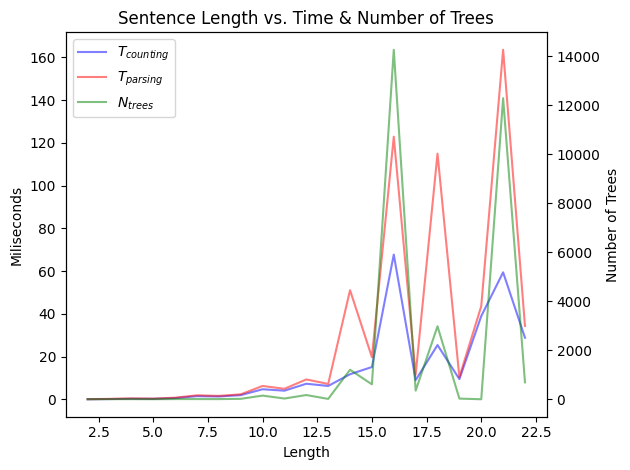

In [14]:
length = sorted(sentence_counts.keys())
ms_counting = [counting_times[k] / sentence_counts[k] for k in length]
ms_parsing = [parsing_times[k] / sentence_counts[k] for k in length]
num_trees = [trees_counts[k] / sentence_counts[k] for k in length]

line_a, = plt.plot(length, ms_counting, label="$T_{counting}$", c="b", alpha=0.5)
line_b, = plt.plot(length, ms_parsing, label="$T_{parsing}$", c="r", alpha=0.5)
plt.xlabel("Length") ; plt.ylabel("Miliseconds")
plt.twinx() ; plt.ylabel("Number of Trees")
line_c, = plt.plot(length, num_trees, label="$N_{trees}$", c="g", alpha=0.5)

lines = [line_a, line_b, line_c]
plt.legend(lines, [x.get_label() for x in lines], loc="upper left")
plt.title("Sentence Length vs. Time & Number of Trees")
plt.tight_layout()
plt.show()

**Disscussion**

Time complexity of the tree-building step in `parse()`:
- Because the parse tree generated by CKY parser must be a full binary tree (ignore the words), the number of nodes is always $L*2-1$ where $L$ is the length of input sentence. Assumed that the number of parse trees is $N$, then the time complexity would be $O(NL)$.
- However, there must be lots of same subtrees inside all the $N$ trees, which will result in a lot of unnecessary duplicate calculations. Therefore, I added a simple optimization strategy, record the span and symbol of subtrees to reuse them with $O(1)$ time complexity. (See `Line 59-64` `BackpointerChart.output()` in `./chart/backpointer.py`)

Compare the speed of `parse()` and `count()`:
- The trends of the three curves are almost synchronized. Generally, the longer the sentence, the more computation time is required.
- In most cases, $T_{counting} < T_{parsing}$. Because `count()` methods perform CKY algorithm and calculate the number of trees without compute all the parse trees. On the contrary, `parse()` need additional $O(NL)$ time to build all the trees. When the results contain a large number of parse trees, their gaps of time become extremely large.

Note that the time cost of some data points is unusually high. We can see that these data points are accompanied by a very large number of parse trees ($N_{trees}>10000$). This is caused by the two inner loops of CKY algorithm:

```
for each B in Ch(i,i+k) and C in Ch(i+k,i+b):
    for each production rule A -> B C:
        add A to Ch(i, i+b)
```

- These two inner loops actually require $O(|G|)$ time complexty, in which $G$ is the grammar. We can see that, in the expirment, $|G|>10000$ while $L<23$, this means that $|G|\gt L^3$ in most cases.
- In general, there are only few trees ($N_{trees}<1000$), then the number of trials $|Ch(i,i+k)\times Ch(i+k,i+b)|$ is extremely small for us to ignore the effect of $O(|G|)$.
- However, when there are a large number of trees, the influence of $|G|$ becomes so great that it cannot be ignored. The time complexity in such a case is $O(L^3|G|)$ for CKY algorithm, and with the approximated values $L^3|G|\approx N^6\approx 10^6$ in this expirment. This amount of computation would indeed take the order of magnitude around 100ms, which is consistent with experimental result.

## Labeled / Unlabeled Tree F1 Score

In [15]:
# Use the "But the concept is workable" example in the slide for parsing.
# Page 25 https://moodle.uni-saarland.de/pluginfile.php/890879/mod_resource/content/5/08%20PCFGs.pdf

# Hardcode the trees with post-order sequence.
# The structure is (parent, child1, child2, ...).
# Note that words (terminals) could not occur as parent.
gold_postorder = [
    ("CC", "But"),
    ("DT", "the"),
    ("NN", "concept"),
    ("NP-SBJ", "DT", "NN"),
    ("VBZ", "is"),
    ("JJ", "workable"),
    ("ADJP", "JJ"),
    ("VP", "VBZ", "ADJP"),
    ("S", "CC", "NP-SBJ", "VP"),
]
parse_postorder = [
    ("IN", "But"),
    ("DT", "the"),
    ("NP", "DT"),
    ("PP", "IN", "NP"),
    ("NN", "concept"),
    ("NP-SBJ", "NN"),
    ("VBZ", "is"),
    ("JJ", "workable"),
    ("ADJP", "JJ"),
    ("VP", "VBZ", "ADJP"),
    ("S", "PP", "NP-SBJ", "VP"),
]


# Build trees from post-order sequences, we can just use iteration instead of recursion.
def build_tree_from_postorder(postorder: list[tuple[str, ...]]) -> nltk.Tree:
    # Record subtrees. Post-order gaurantees that all subtrees must be in the buffer when building parent.
    tree_buffer = dict[str, nltk.Tree]()
    for nodes in postorder:
        symbol, *children = nodes
        assert len(children) > 0
        if len(children) == 1 and children[0] not in tree_buffer:  # leaf aka. word
            tree_buffer[symbol] = nltk.Tree(symbol, children)
            continue
        tree_buffer[symbol] = nltk.Tree(symbol, [tree_buffer.pop(x) for x in children])
    assert tree_buffer.keys() == {"S"}
    return tree_buffer["S"]

gold_tree = build_tree_from_postorder(gold_postorder)
parse_tree = build_tree_from_postorder(parse_postorder)

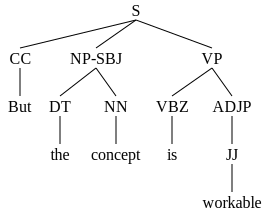

In [16]:
gold_tree

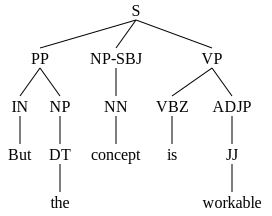

In [17]:
parse_tree

In [18]:
labeled_f1 = tree_f1_score(gold_tree, parse_tree, unlabeled=False)
unlabeled_f1 = tree_f1_score(gold_tree, parse_tree, unlabeled=True)
print("Labeled F1:", labeled_f1)    # Should be 0.700
print("Unlabeled F1:", tree_f1_score(gold_tree, parse_tree, unlabeled=True))    # Should be 0.899

Labeled F1: 0.7000000000000001
Unlabeled F1: 0.8988764044943819


## PCFG Building

In [19]:
# Counting the rules on the trees
leaf_counts = defaultdict[tuple[str, str], int](lambda: 0)          # (T <- NT) => count
nonleaf_counts = defaultdict[tuple[str, str, str], int](lambda: 0)  # (L R <- P) => count
left_hand_counts = defaultdict[str, int](lambda: 0)                 # NT | P => count

def traverse(tree: nltk.Tree) -> None:
    assert 1 <= len(tree) <= 2
    parent: str = tree.label()
    left_hand_counts[parent] += 1
    if len(tree) == 1:  # leaf
        child = tree[0]
        assert isinstance(child, str)
        leaf_counts[(child, parent)] += 1
        return
    left, right = tree
    assert isinstance(left, nltk.Tree) and isinstance(right, nltk.Tree)
    nonleaf_counts[(left.label(), right.label(), parent)] += 1
    traverse(left)
    traverse(right)

# Use the standard CKY Parser to produce all possible trees.
trees = sum([parser.parse(senten) for senten in sentences], [])
for t in trees: traverse(t) # Counting rules on all these trees.

# Build PCFG
leaf_probs = {k: v / left_hand_counts[k[-1]] for k, v in leaf_counts.items()}
nonleaf_probs = {k: v / left_hand_counts[k[-1]] for k, v in nonleaf_counts.items()}
productions = [
    nltk.ProbabilisticProduction(nltk.Nonterminal(k[-1]), [k[-2]], prob=v)
    for k, v in leaf_probs.items()
] + [
    nltk.ProbabilisticProduction(nltk.Nonterminal(k[-1]), (nltk.Nonterminal(kk) for kk in k[:-1]), prob=v)
    for k, v in nonleaf_probs.items()
]

pcfg = nltk.PCFG(grammar.start(), productions)
assert pcfg.is_chomsky_normal_form()
print(pcfg)

Grammar with 1948 productions (start state = SIGMA)
    NP_PPSS -> 'i' [0.999936]
    VERB_MD -> 'need' [0.222298]
    NOUN_NP -> 'a' [0.034373]
    NOUN_NN -> 'flight' [0.0368262]
    PREP_IN -> 'from' [0.335091]
    NOUN_NP -> 'charlotte' [0.00874029]
    PREP_IN -> 'to' [0.281971]
    las -> 'las' [1.0]
    vegas -> 'vegas' [1.0]
    NP_WPS -> 'that' [0.997166]
    VERB_VBZ -> 'makes' [0.561692]
    ADJ_AT -> 'a' [0.356738]
    NOUN_NN -> 'stop' [0.00794938]
    PREP_IN -> 'in' [0.145356]
    saint -> 'saint' [1.0]
    louis -> 'louis' [1.0]
    pt_char_per -> '.' [1.0]
    NP_NP -> 'a' [0.0368162]
    PREP_IN -> 'a' [0.0501992]
    NOUN_NP -> 'saint' [0.075918]
    NOUN_NP -> 'louis' [0.00335725]
    NAPPOS_NP -> 'louis' [0.0322045]
    AVPNP_NP -> 'louis' [0.0668989]
    NP_NP -> 'saint' [0.0379936]
    VERB_VB -> 'saint' [0.0786253]
    INFCL_VB -> 'stop' [0.00318314]
    AVP_RB -> 'to' [0.534586]
    AVPNP_NN -> 'stop' [0.000451824]
    INFCL_VB -> 'flight' [0.0114442]
    VERB_

## Viterbi CKY

In [20]:
FLOAT_EPS = 1e-7
nltk_parser = nltk.parse.ViterbiParser(pcfg)
parser = CkyParser(pcfg)
all_gt_trees: list[nltk.ProbabilisticTree | None] = [None] * len(sentences)
all_trees = all_gt_trees.copy()

for idx, senten in enumerate(sentences):
    tree = parser.viterbi(senten, leaf_probs, nonleaf_probs)
    try:
        gt_tree = list[nltk.ProbabilisticTree](nltk_parser.parse(senten))
    except ValueError:
        gt_tree = []
    if tree is None or len(gt_tree) == 0:
        assert tree is None and len(gt_tree) == 0
        assert gt_counts[idx] == 0
        continue

    assert len(gt_tree) == 1
    assert gt_counts[idx] > 0
    gt_tree = gt_tree[0]

    assert abs(gt_tree.logprob() - tree.logprob()) < FLOAT_EPS
    f1 = tree_f1_score(tree, gt_tree, unlabeled=False)
    if abs(f1 - 1.0) >= FLOAT_EPS:
        assert abs(tree_f1_score(tree, gt_tree, unlabeled=True) - 1.0) < FLOAT_EPS
        print(f"At {idx} found two different trees with same probability, with labeled-f1={f1:.4f} and unlabeled-f1={1.0}")
    all_trees[idx] = tree
    all_gt_trees[idx] = gt_tree

print("All parse trees generated by my ViterbiCKY have same probability as nltk.ViterbiParser")

At 60 found two different trees with same probability, with labeled-f1=0.8667 and unlabeled-f1=1.0
At 75 found two different trees with same probability, with labeled-f1=0.8667 and unlabeled-f1=1.0
All parse trees generated by my ViterbiCKY have same probability as nltk.ViterbiParser


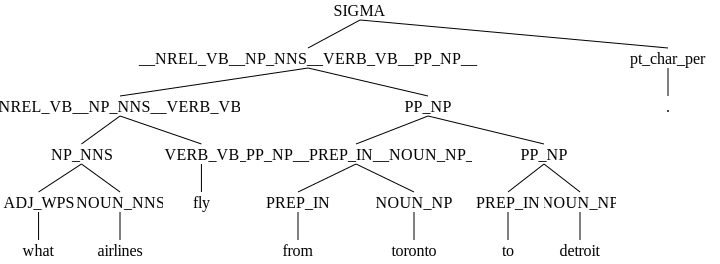

In [21]:
all_trees[60]

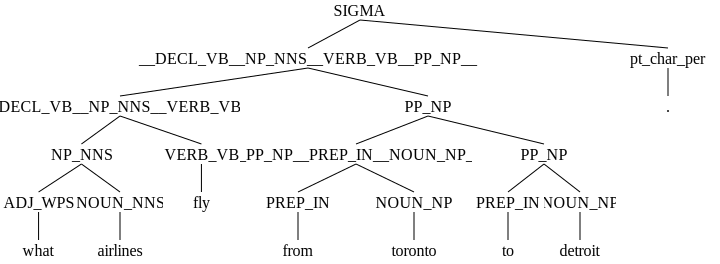

In [22]:
all_gt_trees[60]

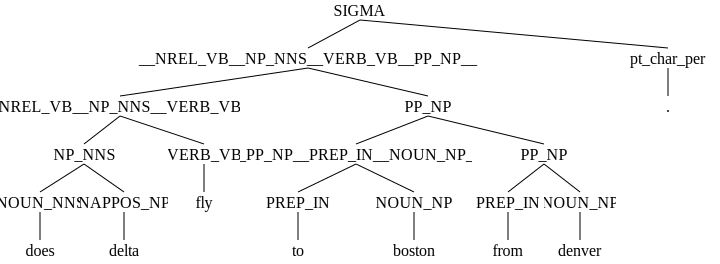

In [23]:
all_trees[75]

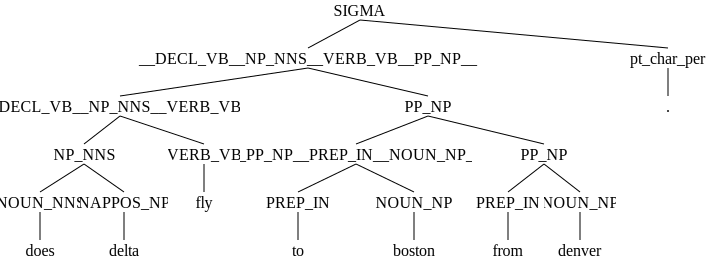

In [24]:
all_gt_trees[75]

In [25]:
print(pcfg.productions(lhs=nltk.Nonterminal("__NREL_VB__NP_NNS__VERB_VB__")))
print(pcfg.productions(lhs=nltk.Nonterminal("__DECL_VB__NP_NNS__VERB_VB__")))
# They are equal when producing in left-hand-side

[__NREL_VB__NP_NNS__VERB_VB__ -> NP_NNS VERB_VB [1.0]]
[__DECL_VB__NP_NNS__VERB_VB__ -> NP_NNS VERB_VB [1.0]]


In [26]:
print(pcfg.productions(rhs=nltk.Nonterminal("__NREL_VB__NP_NNS__VERB_VB__")))
print(pcfg.productions(rhs=nltk.Nonterminal("__DECL_VB__NP_NNS__VERB_VB__")))
# They are not equal when be produced in right-hand-side

[__NREL_VB__NP_NNS__VERB_VB__PP_NP__ -> __NREL_VB__NP_NNS__VERB_VB__ PP_NP [1.0]]
[__DECL_VB__NP_NNS__VERB_VB__NP_NN__ -> __DECL_VB__NP_NNS__VERB_VB__ NP_NN [1.0], __DECL_VB__NP_NNS__VERB_VB__NP_NP__ -> __DECL_VB__NP_NNS__VERB_VB__ NP_NP [1.0], __DECL_VB__NP_NNS__VERB_VB__PP_NP__ -> __DECL_VB__NP_NNS__VERB_VB__ PP_NP [1.0], __DECL_VB__NP_NNS__VERB_VB__PP_NN__ -> __DECL_VB__NP_NNS__VERB_VB__ PP_NN [1.0], __DECL_VB__NP_NNS__VERB_VB__AVPNP_NP__ -> __DECL_VB__NP_NNS__VERB_VB__ AVPNP_NP [1.0]]


In [27]:
print(pcfg.productions(lhs=nltk.Nonterminal("__NREL_VB__NP_NNS__VERB_VB__PP_NP__")))
print(pcfg.productions(lhs=nltk.Nonterminal("__DECL_VB__NP_NNS__VERB_VB__PP_NP__")))
# They are equal when producing in left-hand-side

[__NREL_VB__NP_NNS__VERB_VB__PP_NP__ -> __NREL_VB__NP_NNS__VERB_VB__ PP_NP [1.0]]
[__DECL_VB__NP_NNS__VERB_VB__PP_NP__ -> __DECL_VB__NP_NNS__VERB_VB__ PP_NP [1.0]]


In [28]:
print(pcfg.productions(rhs=nltk.Nonterminal("__NREL_VB__NP_NNS__VERB_VB__PP_NP__")))
print(pcfg.productions(rhs=nltk.Nonterminal("__DECL_VB__NP_NNS__VERB_VB__PP_NP__")))
# They are not equal when be produced in right-hand-side

[SIGMA -> __NREL_VB__NP_NNS__VERB_VB__PP_NP__ pt_char_per [0.0113324], __NREL_VB__NP_NNS__VERB_VB__PP_NP__PP_NP__ -> __NREL_VB__NP_NNS__VERB_VB__PP_NP__ PP_NP [1.0]]
[SIGMA -> __DECL_VB__NP_NNS__VERB_VB__PP_NP__ pt_char_per [0.0113324], __DECL_VB__NP_NNS__VERB_VB__PP_NP__PP_NP__ -> __DECL_VB__NP_NNS__VERB_VB__PP_NP__ PP_NP [1.0], __DECL_VB__NP_NNS__VERB_VB__PP_NP__PP_NN__ -> __DECL_VB__NP_NNS__VERB_VB__PP_NP__ PP_NN [1.0]]


**Discussion**

It's interested that I obtained two pair of trees with f1 != 1 but with same probability. By checking the plots, I found these special pairs. By checking and comparing these pairs, I found that:
- Nonterminals in each pairs are equal when they are in the left-hand-side to produce other non terminals, e.g. both `__NREL_VB__NP_NNS__VERB_VB__` and `__DECL_VB__NP_NNS__VERB_VB__` produces and only produces `NP_NNS VERB_VB` with probability 1.0.
- However, nonterminals in each pairs are not equal when they are in right-hand-side to be produced by other non terminals, e.g. `__NREL_VB__NP_NNS__VERB_VB__` can only be produced by exactly one rule `__NREL_VB__NP_NNS__VERB_VB__PP_NP__ -> __NREL_VB__NP_NNS__VERB_VB__ PP_NP`, while `__DECL_VB__NP_NNS__VERB_VB__` can be produced by multiple rules.

This means that nonterminals in each pairs, although appear equivalent in the results, are actually **inequivalent** in the CFG. For example, `__NREL_VB__NP_NNS__VERB_VB__` paired with `PP_NP` is grammatical, while it could not be paired with `NP_NN`. On the contrary, `__DECL_VB__NP_NNS__VERB_VB__` could be paired with `NP_NN`.

**IMPORTANT: Because the trees with same probability are supposed to be picked randomly, sometimes I get the result that the F1 scores of all tree pairs are exactly equal to 1.0. This also confirms the correctness of my Viterbi CKY parser. If you cannot get the same result in this section, try to restart Jupyter Kernel and rerun this expirment.**

It's worth discussing what causes this randomness:
- Although I use `dict` to store `symbol => backpointer with max log-prob`, `dict` has been guaranteed to be ordered by insertion since `Python 3.7`. Therefore, for the trees with same probability, my algorithm will only choose the first one encountered. 
- In my CFG normalization function `convert_cfg_to_chomsky_normal_form` in `./dataset.py`, I use `set` to store all the productions, which is not guaranteed to be ordered by `Python`. Hence, the order of productions with same probability will change with each run.
- In conclusion, the random order of rules in the normalized CFG caused by `set` lead to the different outputs of my Viterbi CKY parser in each run.

**This is also why I did not follow the advice to use `set` and `nltk.ImmutableTree`** to store the trees generated by standard CKY parser. I think it's not a good idea to use unnecessary `set`:
- **Why it is unnecessary:** In the algorithm, because we need to convert the CFG into `dict` that map `(B,C) => {A for all productions A -> BC}`, potentional duplicate productions in the CFG must be removed. So that the CKY parser would never record duplicate backpointers in the chart. Therefore, no same trees would be built in the building step. This has been verified by comparing the ground truths against the outputs from my implementation with `list[nltk.Tree]` rather than `set[nltk.ImmutableTree]` to store trees.
- in contrast, if the algorithm does indeed produce duplicate trees, there must be some flaws in the implementation, and using `set` **only masks the flaws**.
- Storing objects in set need to calculate their hash values in addition. **It will take $O(N)$ to calculate the hash value of a tree**.
- Although it doesn't affect the correctness, this uncontrollable randomness may **confuse the developers**. For example, I need to run it many times to produce the phenomenon mentioned in this discussion.